In [1]:
from __future__ import print_function

import argparse
import numpy as np

import neuroglancer
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from glob import glob

In [8]:
stack = 'MD594'
source_dir = os.environ['ROOT_DIR']
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
with open(source_dir+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}
fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
annotation = np.load(source_dir+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')
contours_struc = contours.groupby('name')
valid_sections = np.sort(contours['section'].unique())

paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures
all_structures = np.array(all_structures)

In [3]:
contours[(contours['name']=='VCA') & (contours['section']==94)]['vertices'].to_list()[0]

array([[7846.35119146, 7025.37862291],
       [7727.78491719, 6973.16629019],
       [7662.61929633, 6922.79994021],
       [7665.50842641, 6848.03215937],
       [7804.54138864, 6725.98528806],
       [7876.96147159, 6692.33823903],
       [8004.30597918, 6660.50284246],
       [8148.96125467, 6652.67015243],
       [8198.16822747, 6671.38060947],
       [8229.87954194, 6725.54976801],
       [8153.43742976, 6783.68014746],
       [8079.83687836, 6832.59923901],
       [8065.69773499, 6881.70322097],
       [8002.96956383, 6939.52462793],
       [7964.69039281, 6999.8442929 ],
       [7912.21665689, 7039.14013322]])

In [10]:
for struc in contours_grouped.get_group(110)['name'].unique():
    print(struc)

VCA
VCP
DC


In [12]:
np.where(all_structures=='3N')[0][0]

13

In [15]:
np.where(valid_sections==110)[0][0]

16

In [80]:
%%time
margin = 200/0.46
m = 11104
n = 17216
locations = np.zeros((4, len(all_structures), len(valid_sections)))
for section in valid_sections:
    structures = contours_grouped.get_group(section)['name'].unique()
    seq_section = np.where(valid_sections==section)[0][0]
    for structure in structures:
        if structure in all_structures:
            polygon = contours[(contours['name']==structure) & (contours['section']==section)]['vertices'].to_list()[0]
            seq_struc = np.where(all_structures==structure)[0][0]
#             locations[:, seq_struc, seq_section] = np.array([int(max(min(polygon[:, 0]), 0)),
#                                                             int(min(np.ceil(max(polygon[:, 0])), n)),
#                                                             int(max(min(polygon[:, 1]), 0)),
#                                                             int(min(np.ceil(max(polygon[:, 1])), m))])
            locations[:, seq_struc, seq_section] = np.array([int(max(min(polygon[:, 0]) - margin, 0)),
                                                            int(min(np.ceil(max(polygon[:, 0]) + margin), n)),
                                                            int(max(min(polygon[:, 1]) - margin, 0)),
                                                            int(min(np.ceil(max(polygon[:, 1]) + margin), m))])


CPU times: user 2.53 s, sys: 34.3 ms, total: 2.56 s
Wall time: 2.57 s


In [67]:
seq_struc = np.where(all_structures=='VCA')[0][0]
locations[:, seq_struc, :]

array([[7227., 7092., 6936., ..., 6752., 6790.,    0.],
       [8665., 8897., 9214., ..., 9010., 8993.,    0.],
       [6217., 6190., 6150., ..., 5889., 5904.,    0.],
       [7474., 7561., 7698., ..., 7394., 7337.,    0.]])

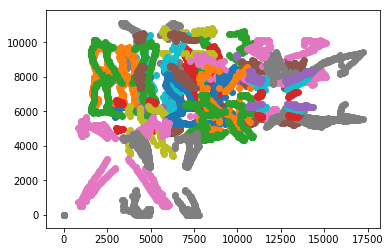

In [81]:
for i in range(len(all_structures)):
    x = np.concatenate((locations[0,i,:], locations[0,i,:], locations[1,i,:], locations[1,i,:]))
    y = np.concatenate((locations[2,i,:], locations[3,i,:], locations[2,i,:], locations[3,i,:]))
    plt.scatter(x, y)
#     plt.scatter(locations[0,i,:], locations[2,i,:])

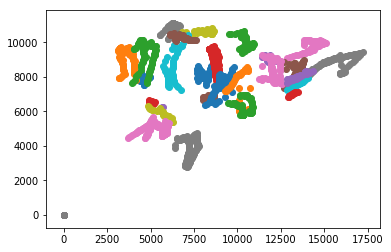

In [57]:
for i in range(len(all_structures)):
    plt.scatter(locations[1,i,:], locations[3,i,:])

In [82]:
%%time
group = {}
for i in range(len(all_structures)):
    subgroup = list(all_structures)
    for j in range(len(all_structures)):
#         if j==i:
#             continue
        for z in range(len(valid_sections)):
            if (locations[0,i,z]-locations[1,j,z])>=0:
                continue
            if (locations[1,i,z]-locations[0,j,z])<=0:
                continue
            if (locations[2,i,z]-locations[3,j,z])>=0:
                continue
            if (locations[3,i,z]-locations[2,j,z])<=0:
                continue
            subgroup.remove(all_structures[j])
            break
    group[all_structures[i]] = subgroup

CPU times: user 209 ms, sys: 4.21 ms, total: 213 ms
Wall time: 214 ms


In [89]:
for structure in all_structures:
    print(structure, [x for x in all_structures if x not in group[structure]])

5N ['5N', '7N', '7n', 'VLL']
6N ['6N', '7n']
7N ['5N', '7N', '7n', 'Amb', 'Sp5O']
7n ['5N', '6N', '7N', '7n', 'LC', 'VLL', 'Sp5O']
Amb ['7N', 'Amb', 'LRt']
LC ['7n', 'LC']
LRt ['Amb', 'LRt', 'Sp5I', 'Sp5O', 'Sp5C']
Pn ['Pn', 'Tz', 'SNC', 'SNR', 'RtTg']
Tz ['Pn', 'Tz', 'RtTg']
VLL ['5N', '7n', 'VLL', 'SNR', 'PBG']
RMC ['RMC', 'SNR', '3N', '4N', 'RtTg']
SNC ['Pn', 'SNC', 'SNR']
SNR ['Pn', 'VLL', 'RMC', 'SNC', 'SNR', 'PBG', 'RtTg']
3N ['RMC', '3N', '4N']
4N ['RMC', '3N', '4N']
Sp5I ['LRt', 'Sp5I', 'Sp5O', 'Sp5C', 'DC']
Sp5O ['7N', '7n', 'LRt', 'Sp5I', 'Sp5O', 'Sp5C', 'DC']
Sp5C ['LRt', 'Sp5I', 'Sp5O', 'Sp5C']
PBG ['VLL', 'SNR', 'PBG', 'SC', 'IC']
10N ['10N', 'AP', '12N']
VCA ['VCA', 'VCP', 'DC']
VCP ['VCA', 'VCP', 'DC']
DC ['Sp5I', 'Sp5O', 'VCA', 'VCP', 'DC']
AP ['10N', 'AP', '12N']
12N ['10N', 'AP', '12N']
RtTg ['Pn', 'Tz', 'RMC', 'SNR', 'RtTg']
SC ['PBG', 'SC', 'IC']
IC ['PBG', 'SC', 'IC']


In [190]:
sets = {}
sets_left = list(all_structures)
count = [6, 6, 6, 3, 2]
for i in range(5):
    subset = []
    subset.append(sets_left[0])
    common = [x for x in group[sets_left[0]] if x in sets_left]
    sets_left.pop(0)
    for j in range(count[i]):
        seq = np.random.choice(len(common),1)[0]
        subset.append(common[seq])
        sets_left.remove(common[seq])
        common = [x for x in common if (x in group[common[seq]]) & (x in sets_left)]
    sets[i] = subset

In [192]:
sets

{0: ['5N', 'Sp5C', 'Tz', 'SNC', 'LC', 'SC', '12N'],
 1: ['6N', '3N', 'VLL', 'Sp5I', '7N', 'IC', 'AP'],
 2: ['7n', 'RMC', 'Pn', 'Amb', '10N', 'DC', 'PBG'],
 3: ['LRt', 'SNR', '4N', 'VCA'],
 4: ['Sp5O', 'RtTg', 'VCP']}

In [193]:
a = {0: ['5N', 'Sp5C', 'Tz', 'SNC', 'LC', 'SC', '12N'],
 1: ['6N', '3N', 'VLL', 'Sp5I', '7N', 'IC', 'AP'],
 2: ['7n', 'RMC', 'Pn', 'Amb', '10N', 'DC', 'PBG'],
 3: ['LRt', 'SNR', '4N', 'VCA'],
 4: ['Sp5O', 'RtTg', 'VCP']}

In [2]:
! python ../scripts/Cell_mark_v2.py

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
python(9429,0x106ff7d40) malloc: *** error for object 0x7fff96c03c90: pointer being freed was not allocated
python(9429,0x106ff7d40) malloc: *** set a breakpoint in malloc_error_break to debug


In [3]:
%%time
structure = 'VCA'
margin = 500/0.46
m = 11104
n = 17216
left_max, right_max, up_max, down_max = n, 0, m, 0
for section in valid_sections:
    try:
        polygon = contours[(contours['name']==structure) & (contours['section']==section)]['vertices'].to_list()[0]
        [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                                   int(min(np.ceil(max(polygon[:, 0]) + margin), n)),
                                   int(max(min(polygon[:, 1]) - margin, 0)),
                                   int(min(np.ceil(max(polygon[:, 1]) + margin), m))]
        if left<left_max:
            left_max = left
        if right>right_max:
            right_max = right
        if up<up_max:
            up_max = up
        if down>down_max:
            down_max = down
    except:
        continue

CPU times: user 369 ms, sys: 12.4 ms, total: 381 ms
Wall time: 375 ms


In [23]:
left_max, right_max, up_max, down_max

(5205, 10467, 4589, 9195)

In [7]:
x.shape

(4, 265, 4606, 5262)

In [8]:
section = valid_sections[0]
src = glob(source_dir+'CSHL_cells_mark/'+stack+'/'+structure+'/'+ str(section) + '*.png')[0]
img = cv2.imread(src,-1)

In [10]:
img = np.moveaxis(img, -1, 0)
img.shape

(4, 11104, 17216)

In [4]:
%%time
structure = 'VCA'
mark = np.zeros((4,len(valid_sections), down_max-up_max, right_max-left_max), dtype=np.uint8)
for i in range(len(valid_sections)):
    section = valid_sections[i]
    src = glob(source_dir+'CSHL_cells_mark/'+stack+'/'+structure+'/'+ str(section) + '*.png')[0]
    img = cv2.imread(src,-1)
    img = np.moveaxis(img, -1, 0)
    mark[:,i,:,:] = img[:, up_max:down_max, left_max:right_max]
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
CPU times: user 9min, sys: 2min 28s, total: 11min 

In [5]:
mark.shape

(4, 265, 4606, 5262)

In [24]:
viewer = neuroglancer.Viewer()

# a = np.zeros((3, 100, 100, 100), dtype=np.uint8)
# ix, iy, iz = np.meshgrid(* [np.linspace(0, 1, n) for n in a.shape[1:]], indexing='ij')
# a[0, :, :, :] = np.abs(np.sin(4 * (ix + iy))) * 255
# a[1, :, :, :] = np.abs(np.sin(4 * (iy + iz))) * 255
# a[2, :, :, :] = np.abs(np.sin(4 * (ix + iz))) * 255

a = np.zeros((100,100,100), dtype=np.uint8)
a[:,:,:]=2

b = np.zeros((100,100,100), dtype=np.uint8)
b[:,:,:]=3


with viewer.txn() as s:
    s.layers['image'] = neuroglancer.ImageLayer(
        # source='precomputed://gs://neuroglancer-public-data/flyem_fib-25/image',
        source='precomputed://https://mousebrainatlas-datajoint-jp2k.s3.amazonaws.com/precomputed/MD594_fullres',
    )
    s.layers['VCA'] = neuroglancer.SegmentationLayer(
        source=neuroglancer.LocalVolume(mark, voxel_size=[460, 460, 20000], offset=[up_max, left_max, 94])
    )
#     s.layers['cube_2'] = neuroglancer.SegmentationLayer(
#         source=neuroglancer.LocalVolume(b, voxel_size=[10000, 10000, 10000], voxel_offset=[200, 200, 0])
#     )
#     s.voxel_coordinates = [3000, 3000, 3000]
print(viewer.state)
print(viewer)

ViewerState({"layers": [{"type": "image", "source": "precomputed://https://mousebrainatlas-datajoint-jp2k.s3.amazonaws.com/precomputed/MD594_fullres", "name": "image"}, {"type": "segmentation", "source": "python://f6fe4edebb7cbe31d60aca77484d995fbd5e82e3.18a94c12a0d063476c3e6c74444649af5669482b", "name": "VCA"}]})
http://127.0.0.1:54136/v/f6fe4edebb7cbe31d60aca77484d995fbd5e82e3/


Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/tornado/iostream.py", line 713, in _handle_events
    self._handle_write()
  File "/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/tornado/iostream.py", line 1063, in _handle_write
    self._write_buffer.advance(num_bytes)
  File "/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/sit

In [5]:
neuroglancer.ImageLayer()

ImageLayer({"type": "image"})